In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import math
import random
import os
import matplotlib.pyplot as plt
import parallel_plume_sim as pps
import multiprocessing
from scipy.interpolate import splprep, splev

##animating
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go
import plotly.io as py

## training
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'parallel_plume_sim'

In [ ]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

In [4]:
puff_data_filename = '~/DataAnalysis/data/puff_data/fromToha/puff_data_20230419_153117.pickle'

# how many seconds to include per chunk?
max_time = 2

# maximum distance in x and y to consider puffs before ignoring them?
min_x = -5
max_x = 20
min_y = -5
max_y = 20

pps.read_puff_data.split_puff_data_into_smaller_dataframes_and_cull_old_puffs(puff_data_filename, 
                                                                              max_time, 
                                                                              min_x, max_x, 
                                                                              min_y, max_y)

Creating directory:  /home/flybot/DataAnalysis/data/puff_data/fromToha/puff_data_20230419_153117


In [5]:
# This should match your directory name from above -- you need to change this
dirname = '/home/flybot/DataAnalysis/data/puff_data/fromToha/puff_data_20230419_153117'
# Class for reading puff data
puff_reader = pps.read_puff_data.PuffReader(dirname)

### Create a Trajectory

In [6]:
# n_points = 200 * 60  # 200Hz for 1 minute, change as needed
# step_size = 0.05  # meters

# steps = np.random.uniform(low=-step_size, high=step_size, size=(n_points, 2))
# points = np.cumsum(steps, axis=0)

# # Ensure the last point is (0,0) by shifting all points by the last point
# points -= points[-1]

# # Scale and shift the points to the desired range
# points[:, 0] = ((points[:, 0] - np.min(points[:, 0])) / (np.max(points[:, 0]) - np.min(points[:, 0])) * 5) + 5
# points[:, 1] = ((points[:, 1] - np.min(points[:, 1])) / (np.max(points[:, 1]) - np.min(points[:, 1])) * 13) + 2

# x = points[:,0]
# y = points[:,1]
# time = np.linspace(1,149,len(x))
# time = np.round(time, decimals=2)


In [7]:
# # Create a 10x10 grid
# f, ax = plt.subplots(figsize=(5,4))
# ax.grid(False)
# ax.scatter(x,y, s=1)
# # f.savefig('traject.jpg')

### Generate Trajectories and Collect Odor Encounters

In [14]:
def process_position(position):
    time, x, y = position
    concentration, wind_x, wind_y = puff_reader.get_odor_concentration_at_t_and_position(time, x, y)
    return concentration, wind_x, wind_y


def generate_trajectory(x_limits, y_limits, n_waypoints, noise_scale, n_eval_points):
    # Generate waypoints along a diagonal line, then add some random noise
    waypoints = np.zeros((n_waypoints, 2))
    waypoints[:, 0] = np.linspace(x_limits[0], x_limits[1], n_waypoints)
    waypoints[:, 1] = np.linspace(y_limits[0], y_limits[1], n_waypoints)
    waypoints += noise_scale * np.random.randn(n_waypoints, 2)  # Add noise

    # Generate B-Spline
    tck, u = splprep(waypoints.T, s=0)
    unew = np.linspace(0, 1.0, n_eval_points)
    out = splev(unew, tck)

    return out[0], out[1]  # Returns x and y coordinates of the trajectory



def process_and_save_data(index,foldername):

    n_waypoints=math.floor(random.randint(90,200) / 10) * 10 #multiple of 10
    n_eval_points=math.floor(random.randint(1000,2000) / 50) * 50 #multiple of 50

    x, y = generate_trajectory((0,20),(0,20),n_waypoints,2.5,n_eval_points)
    time = np.linspace(1,149,len(x))
    # plt.plot(x,y)

    with multiprocessing.Pool() as pool:
        results = pool.map(process_position, [(time[i], x[i], y[i]) for i in range(len(x))])

    c = [result[0] for result in results]
    wx = [result[1] for result in results]
    wy = [result[2] for result in results]

    df_new = pd.DataFrame()
    df_new['odor'] = c
    df_new['windx'] = wx
    df_new['windy'] = wy
    df_new['x'] = x
    df_new['y'] = y
    # df_new['time']=time

    filename = '~/DataAnalysis/data/generated_data_plume_sim/'+str(foldername)+'/diag{}.h5'.format(index)
    df_new.to_hdf(filename, key='data', mode='w')


for i in range(1, 2):
    process_and_save_data(i,'test_2')


In [18]:
# Specify the directory you're working from
folder_path = '/home/flybot/DataAnalysis/data/generated_data_plume_sim/train/'

# Get a list of all the .h5 files in the directory
files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

# Initialize an empty dataframe
all_data = pd.DataFrame()

# Loop through the files and read each one into a dataframe
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_hdf(file_path)
    all_data = pd.concat([all_data, df])

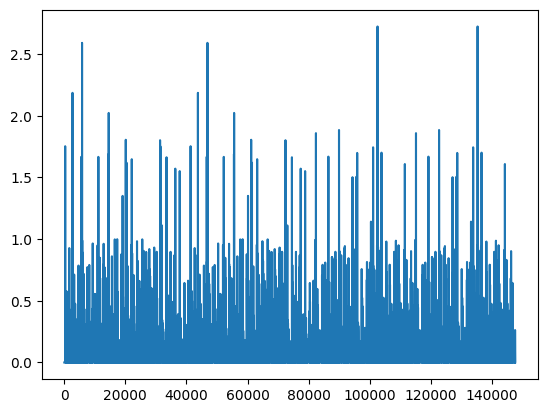

In [19]:
all_data=all_data.reset_index(drop=True)
df=pd.DataFrame()
df = all_data.copy()
plt.plot(df.odor)

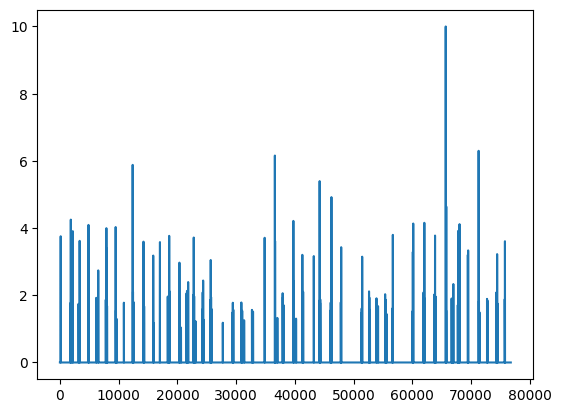

In [12]:
df['scaled_odor']=scale_data(df.odor)
plt.plot(df.scaled_odor)

In [13]:
df.to_hdf('~/DataAnalysis/data/generated_data_plume_sim/train_2/train.h5', key='data', mode='w')

In [17]:
# desertdf=pd.read_hdf('~/DataAnalysis/data/desert/WindyPredictions.h5')
# df = desertdf[:1200]

In [12]:
# Preprocess the data
# features = ['mc_mean', 'ma_max', 'ma_std_dev', 'wd_std_dev']  # 'odor' is not included here
# target = ['distance']

features = ['windx', 'windy', 'x', 'y']  # 'odor' is not included here
target = ['scaled_odor']


scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_features = torch.Tensor(train_df[features].values)
train_targets = torch.Tensor(train_df[target].values)

test_features = torch.Tensor(test_df[features].values)
test_targets = torch.Tensor(test_df[target].values)

# Reshape to (batch_size, seq_length, n_features)
train_features = train_features.view(-1, 1, 4)  # We now have 4 features
test_features = test_features.view(-1, 1, 4)



### RNN Test

In [13]:

# # Define the RNN model
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
#         out, _ = self.rnn(x, h0)  # RNN output and last hidden state
#         out = self.fc(out[:, -1, :])  # Pass RNN output through fully-connected layer
#         return out

# # Initialize the model, loss function and optimizer
# model = RNN(input_size=4, hidden_size=32, output_size=1)  # We now have 4 input features
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Train the model
# num_epochs = 100
# for epoch in range(num_epochs):
#     model.train()
#     outputs = model(train_features)
#     loss = criterion(outputs, train_targets)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch+1) % 10 == 0:
#         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# # Test the model
# model.eval()
# with torch.no_grad():
#     predictions = model(test_features)
#     test_loss = criterion(predictions, test_targets)
# print(f'Test Loss: {test_loss.item()}')

### LSTM Test

In [14]:
# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))  # LSTM output and last hidden state
        out = self.fc(out[:, -1, :])  # Pass LSTM output through fully-connected layer
        return out

# Move model to the device
model = LSTM(input_size=4, hidden_size=128, output_size=1, num_layers=3, dropout=0.5).to(device)

# Move tensors to the device
train_features = train_features.to(device)
train_targets = train_targets.to(device)
test_features = test_features.to(device)
test_targets = test_targets.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Lower learning rate

# Train the model
num_epochs = 500  # More epochs
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_features)
    loss = criterion(outputs, train_targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Test the model
model.eval()
with torch.no_grad():
    predictions = model(test_features)
    test_loss = criterion(predictions, test_targets)
print(f'Test Loss: {test_loss.item()}')


cuda
Epoch 10/500, Loss: 0.05927552282810211
Epoch 20/500, Loss: 0.05938640236854553
Epoch 30/500, Loss: 0.059247732162475586
Epoch 40/500, Loss: 0.05923924222588539
Epoch 50/500, Loss: 0.05921110510826111
Epoch 60/500, Loss: 0.059200212359428406
Epoch 70/500, Loss: 0.059194792062044144
Epoch 80/500, Loss: 0.05918010696768761
Epoch 90/500, Loss: 0.05917700380086899
Epoch 100/500, Loss: 0.059166569262742996
Epoch 110/500, Loss: 0.05914605036377907
Epoch 120/500, Loss: 0.05913041532039642
Epoch 130/500, Loss: 0.059083253145217896
Epoch 140/500, Loss: 0.0590624138712883
Epoch 150/500, Loss: 0.059015508741140366
Epoch 160/500, Loss: 0.05898323282599449
Epoch 170/500, Loss: 0.058891069144010544
Epoch 180/500, Loss: 0.058665163815021515
Epoch 190/500, Loss: 0.058549914509058
Epoch 200/500, Loss: 0.058191895484924316
Epoch 210/500, Loss: 0.058545202016830444
Epoch 220/500, Loss: 0.05711094290018082
Epoch 230/500, Loss: 0.05671846121549606
Epoch 240/500, Loss: 0.057046595960855484
Epoch 250/50

### GRU Test

In [50]:
# # Define the GRU model
# class GRU(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
#         super(GRU, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
#         out, _ = self.gru(x, h0)  # GRU output and last hidden state
#         out = self.fc(out[:, -1, :])  # Pass GRU output through fully-connected layer
#         return out

# # Check if CUDA is available and set the device accordingly
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = GRU(input_size=4, hidden_size=256, 
#             output_size=1, num_layers=3, dropout=0.5).to(device)  # Increased complexity
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate

# # Move the data to the device
# train_features = train_features.to(device)
# train_targets = train_targets.to(device)
# test_features = test_features.to(device)
# test_targets = test_targets.to(device)

# # Train the model
# num_epochs = 200  # More epochs
# for epoch in range(num_epochs):
#     model.train()
#     outputs = model(train_features)
#     loss = criterion(outputs, train_targets)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch+1) % 20 == 0:
#         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# # Test the model
# model.eval()
# with torch.no_grad():
#     predictions = model(test_features)
#     test_loss = criterion(predictions, test_targets)
# print(f'Test Loss: {test_loss.item()}')


In [15]:
test = pd.read_hdf('/home/flybot/DataAnalysis/data/generated_data_plume_sim/test/diag1.h5')
# test = desertdf[1200:]
# test = test.reset_index(drop=True)

In [16]:
# Assume new_data is a DataFrame with the same structure as your training data
new_df = pd.DataFrame()
new_df['windx']=test.windx
new_df['windy']=test.windy
new_df['x']=test.x
new_df['y']=test.y

In [17]:
# new_df=test.copy()

In [18]:
# Now, let's predict the 'odor' for the new data
# new_features = ['mc_mean', 'ma_max', 'ma_std_dev', 'wd_std_dev'] # 'odor' is not included here
new_features = ['windx', 'windy', 'x', 'y'] # 'odor' is not included here
new_df[new_features] = scaler.transform(new_df[new_features])  # Use the same scaler object as before
new_features_tensor = torch.Tensor(new_df[new_features].values).to(device)  # Move tensor to the same device as the model
new_features_tensor = new_features_tensor.view(-1, 1, 4)  # We now have 4 features

# Generate predictions
model.eval()
with torch.no_grad():
    new_predictions = model(new_features_tensor)


In [19]:
# plt.plot(np.linspace(0,149,len(test)), test_odor)
# plt.xlabel('time,s')
# plt.ylabel('unscaled_odor_actual, v')
# plt.tight_layout()
# plt.xlim(145,150)

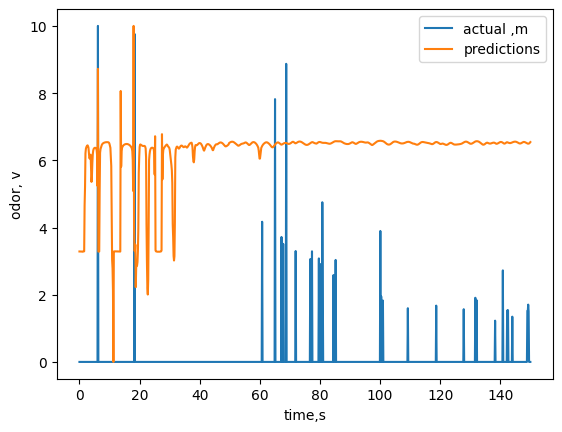

In [22]:
plt.plot(np.linspace(0,150,len(test)),test.odor, label='actual ,m')
plt.plot(np.linspace(0,150,len(test)),new_predictions.cpu().numpy() , label='predictions')
plt.xlabel('time,s')
plt.ylabel('odor, v')
plt.legend()
# plt.savefig('../pred_.jpg')

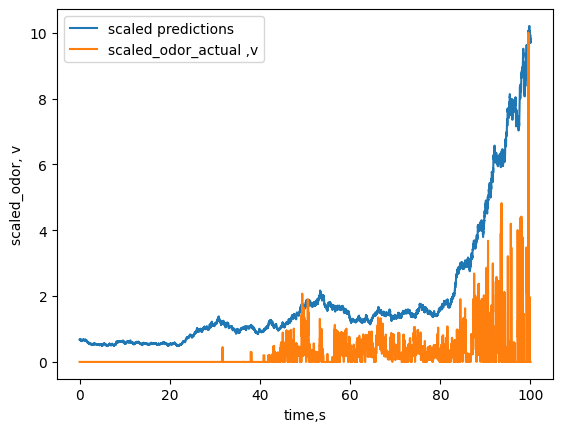

In [125]:
plt.plot(np.linspace(0,100,len(test)),new_predictions.cpu().numpy()*10 , label='scaled predictions')
plt.plot(np.linspace(0,100,len(test)),test_odor, label='scaled_odor_actual ,v')
plt.xlabel('time,s')
plt.ylabel('scaled_odor, v')
plt.legend()

In [134]:
new_ = pd.DataFrame()
new_['actual_odor'] = test.odor
new_['predicted_odor']=new_predictions.cpu().numpy()

In [137]:
new_.to_hdf('~/DataAnalysis/data/act.h5', key='data', mode='w')

In [ ]:
# step_size = 5

# fig = go.Figure(
#     data=[go.Scatter(x=x[:1], y=y[:1], mode='lines')],
#     layout=go.Layout(
#         xaxis=dict(range=[-5,20], autorange=False),
#         yaxis=dict(range=[-5,20], autorange=False),
#         title="Animation of evolving points",
#         shapes=[
#             go.layout.Shape(
#                 type="circle",
#                 xref="x", yref="y",
#                 x0=-0.5, y0=-0.5, x1=0.5, y1=0.5,
#                 line_color="Red",
#                 fillcolor="Red"
#             )
#         ],
#         updatemenus=[dict(
#             type="buttons",
#             buttons=[dict(label="Play",
#                           method="animate",
#                           args=[None, {"frame": {"duration": 100, "redraw": False}}])])],
#         transition = {"duration": 100}
#     ),
#     frames=[go.Frame(
#         data=[go.Scatter(
#             x=x[:k+1:step_size],
#             y=y[:k+1:step_size],
#             mode='lines')]
#     )
#     for k in range(1, len(x), step_size)]
# )

# # # Ensure that the aspect ratio is 1:1
# # fig.update_yaxes(
# #     scaleanchor = "x",
# #     scaleratio = 1,
# # )
# # fig.update_xaxes(
# #     scaleanchor = "y",
# #     scaleratio = 1,
# # )

# fig.show()

